# Exploring the radial properties of the hot-ICM temperature


<span style="color:red">This should currently be considered preliminary, as there are some problems with observation selection for spectral generation for some of these large clusters - also our improved background method isn't fully implemented. Also also, we are still using the MCXC defined coordinates</span>

<span style="color:red">**We do not currently make the temperature profile saves available, as I need to create a better file format for them (i.e. FITS based), and they are probably too large for GitHub right now.**</span>

## Import Statements

In [75]:
import pandas as pd
pd.set_option('display.max_columns', 500)
import numpy as np
from astropy.units import Quantity
from astropy.cosmology import LambdaCDM
from shutil import rmtree
from matplotlib import pyplot as plt
import os

import xga
# This just sets the number of cores this analysis is allowed to use
xga.NUM_CORES = 100
# This is a bodge that will only work because xga_output in notebooks has already been defined, XGA
#  will be made to handle this more gracefully at some point
temp_dir = xga.OUTPUT
actual_dir = temp_dir.split('notebooks/')[0]+'notebooks/xga_output/'
xga.OUTPUT = actual_dir
xga.utils.OUTPUT = actual_dir
# As currently XGA will setup an xga_output directory in our current directory, I remove it to keep it all clean
if os.path.exists('xga_output'):
    rmtree('xga_output')
from xga.samples import ClusterSample
from xga.sourcetools.temperature import min_cnt_proj_temp_prof  
from xga.sas.phot import emosaic
from xga.imagetools.misc import physical_rad_to_pix

%matplotlib inline

In [15]:
xga.__version__

'0+unknown'

## Define the cosmology

We make use of a concordance flat LambdaCDM cosmology during the course of this analysis:

In [2]:
cosmo = LambdaCDM(70, 0.3, 0.7)

## Reading the sample file

We read in the sample file to get the information we need to set up an XGA ClusterSample:

In [3]:
samp = pd.read_csv('../../sample_files/lovoccs_southnorth.csv')
samp

name          MCXC  LoVoCCSID LoVoCCS_name          ra  \
0    MCXCJ1558.3+2713  J1558.3+2713          0    LoVoCCS-0  239.585833   
1    MCXCJ1510.9+0543  J1510.9+0543          1    LoVoCCS-1  227.729167   
2    MCXCJ0258.9+1334  J0258.9+1334          2    LoVoCCS-2   44.739583   
3    MCXCJ1348.8+2635  J1348.8+2635          3    LoVoCCS-3  207.220833   
4    MCXCJ0041.8-0918  J0041.8-0918          4    LoVoCCS-4   10.458750   
..                ...           ...        ...          ...         ...   
142  MCXCJ0448.2-2028  J0448.2-2028        142  LoVoCCS-142   72.050833   
143  MCXCJ2323.8+1648  J2323.8+1648        143  LoVoCCS-143  350.972917   
144  MCXCJ1416.8-1158  J1416.8-1158        144  LoVoCCS-144  214.214583   
145  MCXCJ1459.0-0843  J1459.0-0843        145  LoVoCCS-145  224.764583   
146  MCXCJ0041.7+2124  J0041.7+2124        146  LoVoCCS-146   10.446250   

           dec  redshift       L500    M500    R500         alt_name  \
0    27.226944    0.0894  10.676087  8.1491  1.3803  RXCJ1558.3+2713   
1     5.720000    0.0766   8.726709  7.2708  1.3344            A2029   
2    13.579444    0.0739   6.088643  5.8488  1.2421  RXCJ0258.9+1334   
3    26.595556    0.0622   5.478067  5.5280  1.2236  RXCJ1348.8+2635   
4    -9.301944    0.0555   5.100085  5.3163  1.2103  RXCJ0041.8-0918   
..         ...       ...        ...     ...     ...              ...   
142 -20.469722    0.0720   1.004022  1.9513  0.8620  RXCJ0448.2-2028   
143  16.808889    0.0416   1.002026  1.9896  0.8760            A2589   
144 -11.976111    0.0982   1.001648  1.9133  0.8491  RXCJ1416.8-1158   
145  -8.725000    0.1043   1.001337  1.9047  0.8461  RXCJ1459.0-0843   
146  21.413889    0.1014   1.000012  1.9071  0.8473  RXCJ0041.7+2124   

    other_names     Notes sub_samp  old_LoVoCCSID  
0         A2142         L    north              0  
1         A2029       NaN    south              1  
2          A401         L    south              2  
3         A1795       NaN    north              3  
4           A85  L,losStr    south              4  
..          ...       ...      ...            ...  
142        A514    losStr    south            139  
143       A2589       NaN    north            140  
144         NaN         X    south            141  
145         NaN       NaN    south            142  
146         A84       NaN    north            143  

[147 rows x 15 columns]

In [4]:
samp = samp[samp['LoVoCCS_name'].isin(['LoVoCCS-40', 'LoVoCCS-77'])]
samp

name          MCXC  LoVoCCSID LoVoCCS_name          ra  \
40  MCXCJ1539.5-8335  J1539.5-8335         40   LoVoCCS-40  234.891250   
77  MCXCJ1133.2+6622  J1133.2+6622         77   LoVoCCS-77  173.319583   

          dec  redshift      L500    M500    R500         alt_name  \
40 -83.592222    0.0728  2.235082  3.1770  1.0138  RXCJ1539.5-8335   
77  66.378611    0.1160  1.489357  2.4063  0.9111  RXCJ1133.2+6622   

   other_names Notes sub_samp  old_LoVoCCSID  
40         NaN   NaN    south             39  
77       A1302   NaN    north             76

## Set up an XGA ClusterSample

<span style="color:red">This is currently a bodge, they are some slightly better coordinates to help XGA select the correct region during the set up process. This will be made redundant by updated central positions for the whole sample sometime soon</span>

In [5]:
# samp.loc[95, 'ra'] = 240.56
# samp.loc[95, 'dec'] = 15.965

# samp.loc[130, 'ra'] = 359.713
# samp.loc[130, 'dec'] = -60.642

# samp.loc[89, 'ra'] = 227.865
# samp.loc[89, 'dec'] = 6.349

We set up an XGA ClusterSample to help us manage all the data and analyse the objects. <span style="color:red">The MCXC coordinates are used</span> as the central positions of the clusters, <span style="color:red">as well as the MCXC $R_{500}$ values.</span> 

<span style="color:red">The threshold for an observation being determined as relevant is set to 10% of the $R_{500}$ being on a particular observation.</span> 

In [6]:
ra = samp['ra'].values
dec = samp['dec'].values
name = samp['LoVoCCSID'].apply(lambda x: 'LoVoCCS-' + str(x)).values
z = samp['redshift'].values
r500 = Quantity(samp['R500'].values, 'Mpc')

srcs = ClusterSample(ra, dec, z, name, r500=r500, use_peak=False, clean_obs=True, clean_obs_reg='r500', 
                     clean_obs_threshold=0.1, cosmology=cosmo)

Setting up Galaxy Clusters: 100%|██████████| 2/2 [00:02<00:00,  1.05s/it]
/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/xga/samples/extended.py:246: UserWarning: Non-fatal warnings occurred during the declaration of some sources, to access them please use the suppressed_warnings property of this sample.
  self._check_source_warnings()


0720252501


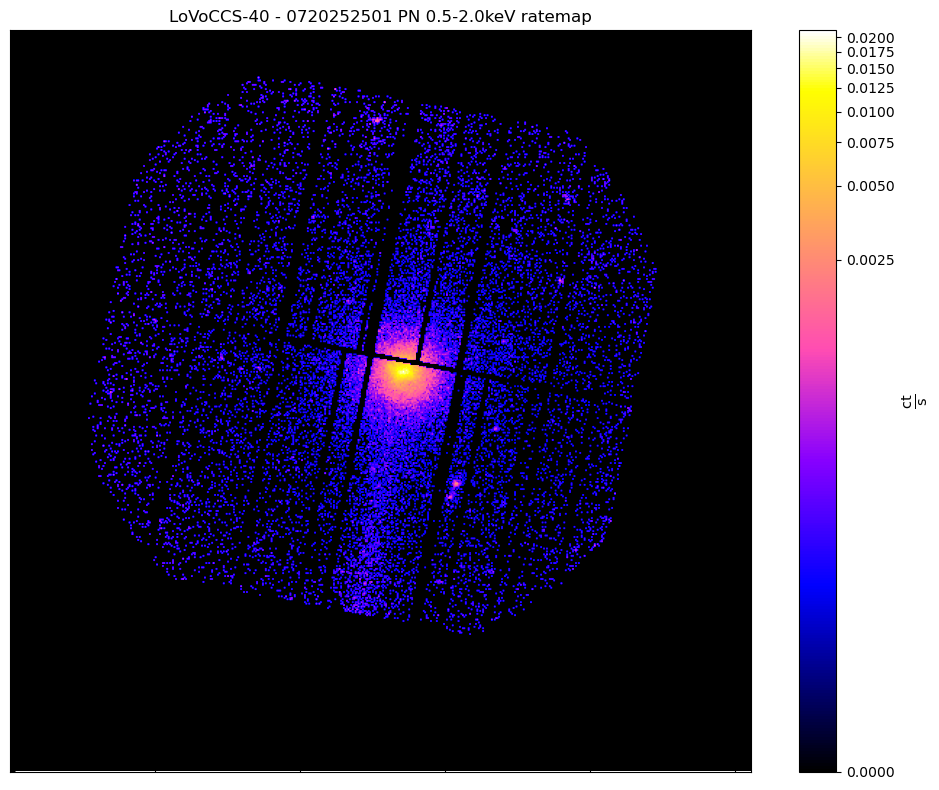

0720252501


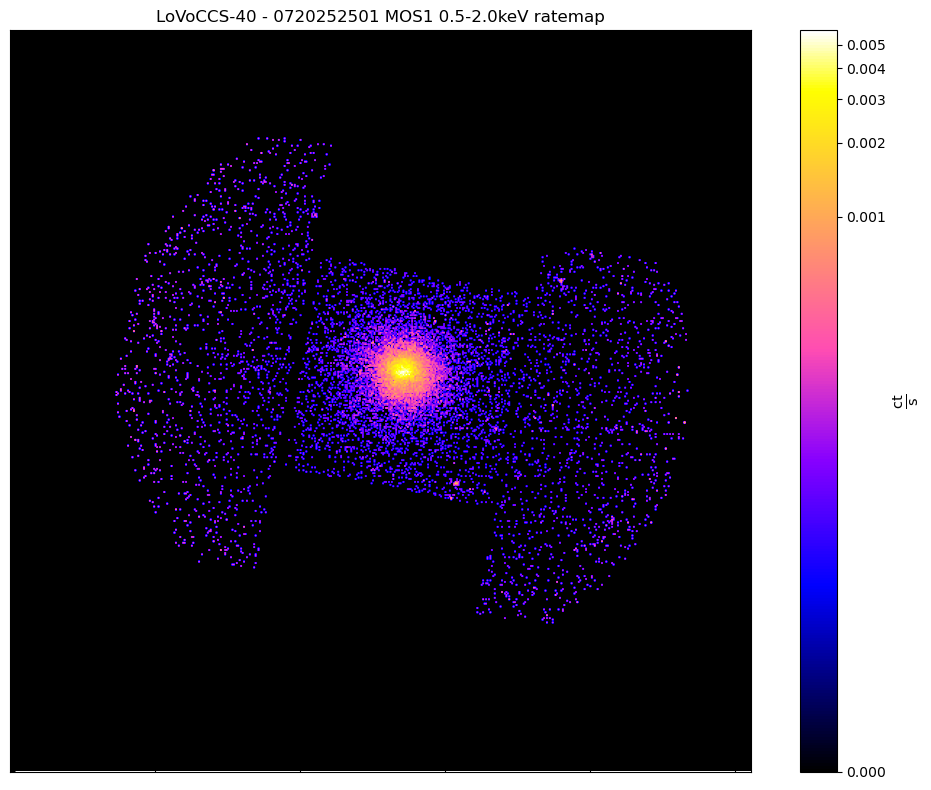

0720252501


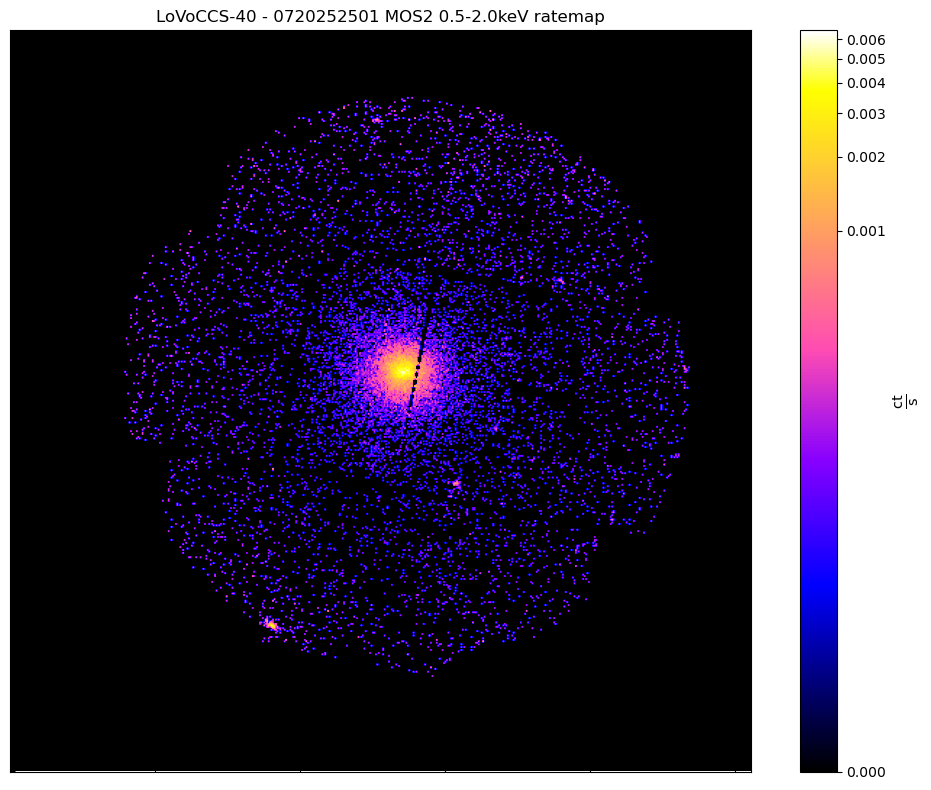

0502671101


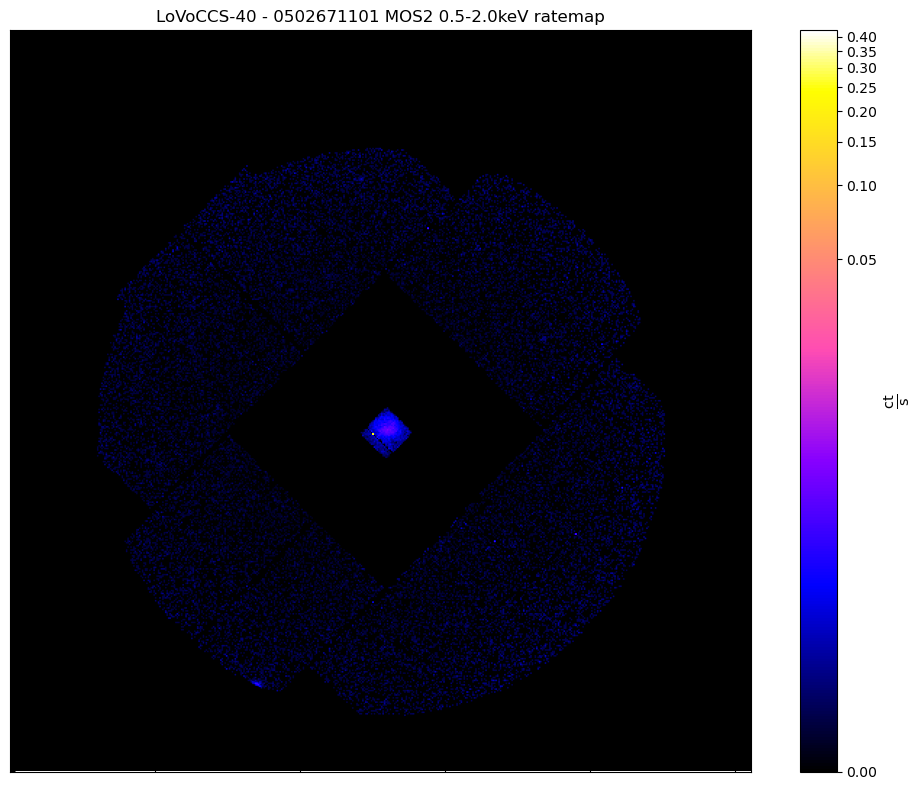




0083150401


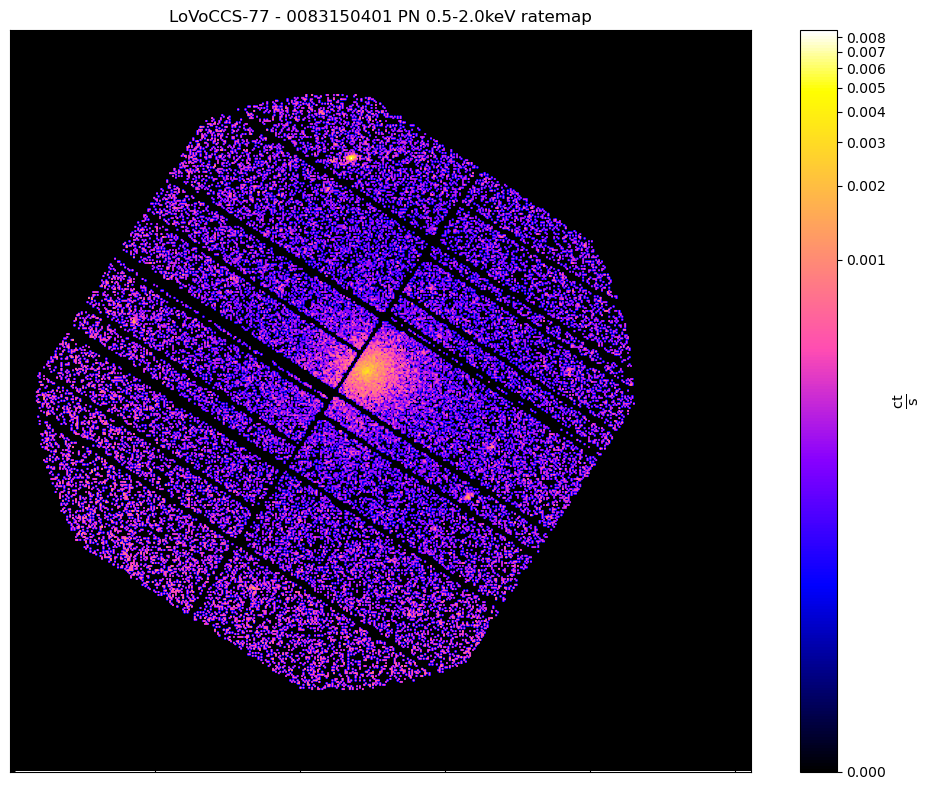

0083150401


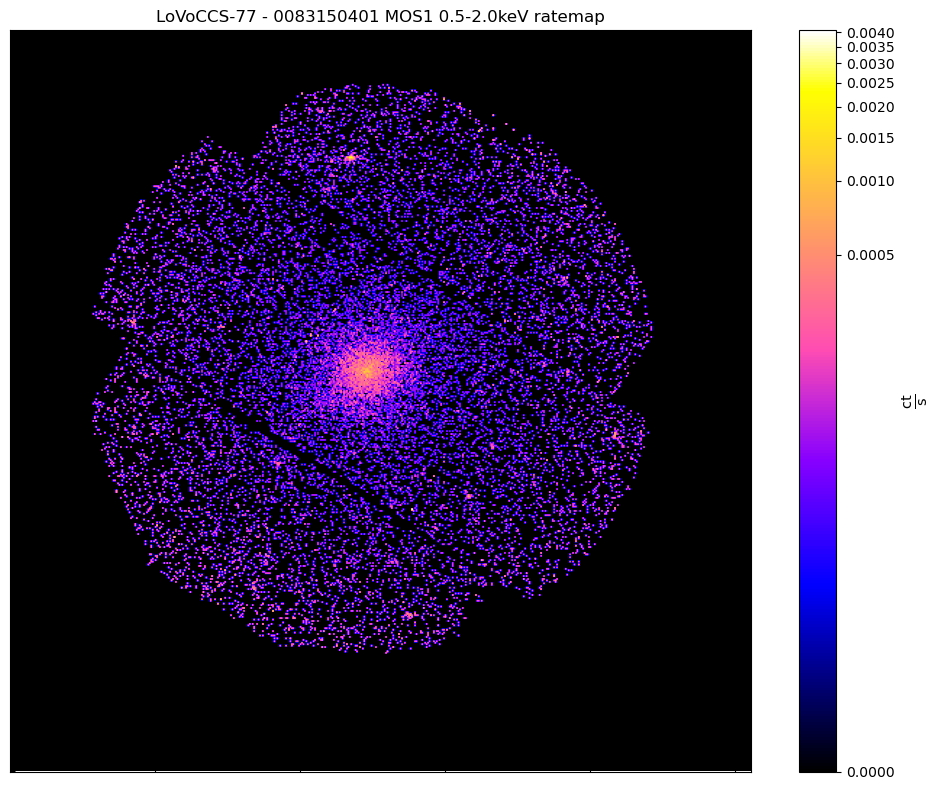

0083150401


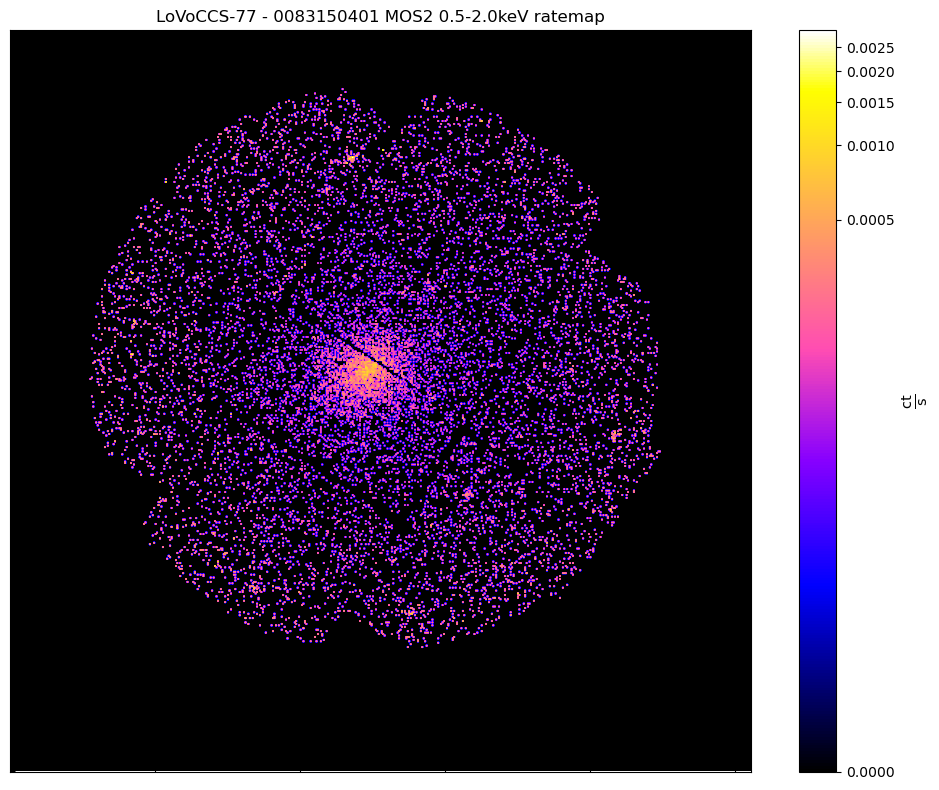

In [12]:
for src in srcs:
    for rt in src.get_ratemaps(lo_en=Quantity(0.5, 'keV'), hi_en=Quantity(2.0, 'keV')):
        print(rt.obs_id)
        rt.view()
        
    print('\n\n')

In [8]:
srcs.info()


-----------------------------------------------------
Number of Sources - 2
Redshift Information - True
Sources with ≥1 detection - 2 [100%]
-----------------------------------------------------



In [57]:
srcs[0].info()


-----------------------------------------------------
Source Name - LoVoCCS-40
User Coordinates - (234.89125, -83.59222222) degrees
nH - 0.0768 1e+22 / cm2
Redshift - 0.073
XMM ObsIDs - 1
PN Observations - 1
MOS1 Observations - 1
MOS2 Observations - 1
On-Axis - 0
With regions - 1
Total regions - 34
Obs with 1 detection - 1
Obs with >1 matches - 0
Total exposure - 25.29 ks
Images associated - 6
Exposure maps associated - 6
Combined Ratemaps associated - 1
Spectra associated - 45
R500 - 1013.8 kpc
R500 SNR - 287.16
-----------------------------------------------------



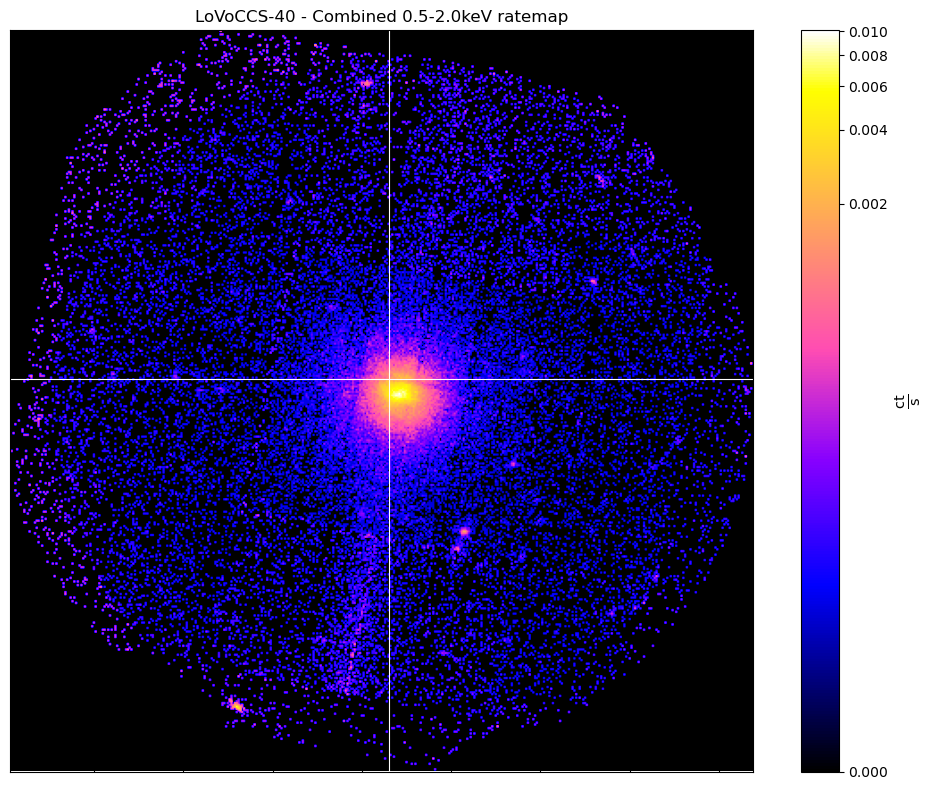

In [74]:
coord = Quantity([234.8471626, -83.5919928], 'deg')
coord = Quantity([234.8921918, -83.5891976], 'deg')
coord = Quantity([234.9636784, -83.5790405], 'deg')


# coord = srcs['LoVoCCS-40'].ra_dec

srcs['LoVoCCS-40'].get_combined_ratemaps().view(coord, zoom_in=True)

In [9]:
stop

NameError: name 'stop' is not defined

In [ ]:
srcs['LoVoCCS-77'].get_products('spectrum', inst='pn')[0].view()

In [ ]:
srcs['LoVoCCS-40'].info()

In [ ]:
srcs['LoVoCCS-40'].get_products('spectrum', inst='pn')[0].view()

In [ ]:
srcs.obs_ids

In [13]:
srcs['LoVoCCS-40'].disassociate_obs({'0502670401': ['mos1', 'mos2'], '0502671101': ['mos2']})

## Generating projected temperature and metallicity profiles

In [14]:
rads = min_cnt_proj_temp_prof(srcs, srcs.r500, Quantity(1500, 'ct'), one_rmf=False, freeze_met=False)

Generating products of type(s) annular spectrum set components: 100%|██████████| 54/54 [25:06<00:00, 27.91s/it]   
Running XSPEC Fits: 100%|██████████| 29/29 [05:12<00:00, 10.76s/it]  


In [21]:
pt_profs = [src.get_proj_temp_profiles() for src in srcs]

97630588


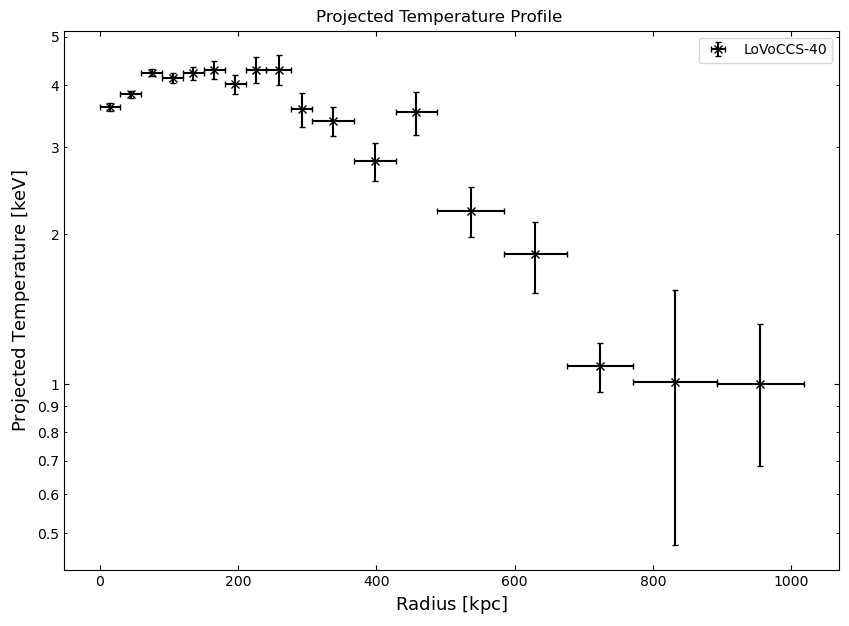

47028287


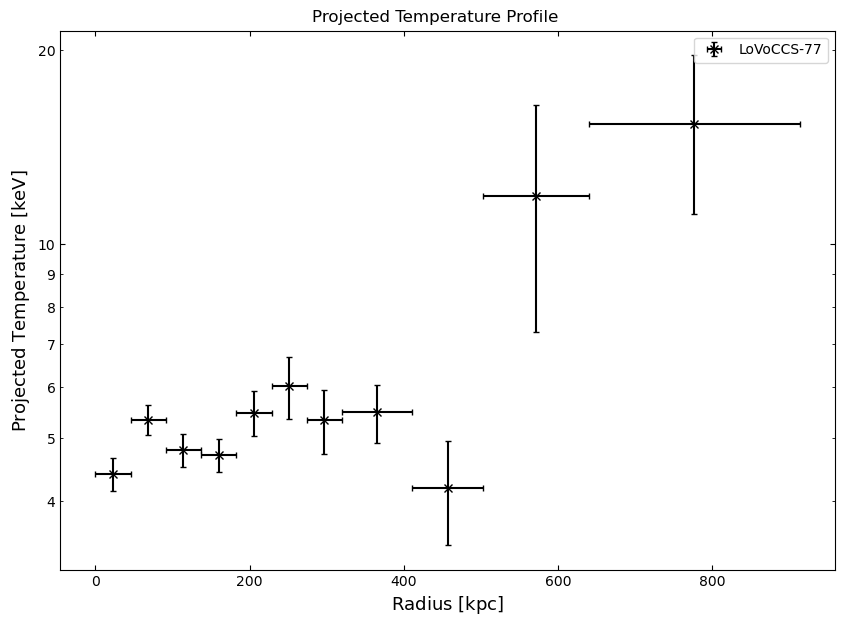

In [32]:
for pt in pt_profs:
    print(pt.set_ident)
    pt.view(xscale='linear')

In [26]:
src.get_profiles('abundace')

/tmp/local/31173032/ipykernel_18527/438374410.py:1: UserWarning: abundace_profile seems to be a custom profile, not an XGA default type. If this is not true then you have passed an invalid profile type.
  src.get_profiles('abundace')


NoProductAvailableError: Cannot find any abundace profiles matching your input.

In [40]:
srcs[0].info()


-----------------------------------------------------
Source Name - LoVoCCS-40
User Coordinates - (234.89125, -83.59222222) degrees
nH - 0.0768 1e+22 / cm2
Redshift - 0.073
XMM ObsIDs - 1
PN Observations - 1
MOS1 Observations - 1
MOS2 Observations - 1
On-Axis - 0
With regions - 1
Total regions - 34
Obs with 1 detection - 1
Obs with >1 matches - 0
Total exposure - 25.29 ks
Images associated - 6
Exposure maps associated - 6
Combined Ratemaps associated - 1
Spectra associated - 45
R500 - 1013.8 kpc
R500 SNR - 287.16
-----------------------------------------------------



In [46]:
ann_spec = srcs[0].get_annular_spectra(set_id=97630588)

In [44]:
met_prof = srcs[0].get_annular_spectra(set_id=97630588).generate_profile('constant*tbabs*apec', 'Abundanc', '')

In [45]:
met_prof.view()

AttributeError: 'NoneType' object has no attribute 'view'

In [58]:
mets = []
for ann_id in ann_spec.annulus_ids:
    print(ann_spec.get_results(ann_id, 'constant*tbabs*apec'))
    mets.append(ann_spec.get_results(ann_id, 'constant*tbabs*apec', 'Abundanc'))
    print('')

{'kT': array([3.60412   , 0.05760787, 0.06810449]), 'Abundanc': array([1.2465    , 0.0726814 , 0.07606594]), 'norm': array([2.1597000e-03, 5.4769430e-05, 5.5696517e-05]), 'factor': array([[1.07547   , 0.02413744, 0.02469179],
       [0.986639  , 0.01896197, 0.01934754]])}

{'kT': array([3.82225   , 0.05136902, 0.05773003]), 'Abundanc': array([1.12417   , 0.05595896, 0.0578689 ]), 'norm': array([3.7937600e-03, 7.2280058e-05, 7.3346324e-05]), 'factor': array([[1.00138   , 0.0175246 , 0.01782806],
       [0.921169  , 0.01355771, 0.01376793]])}

{'kT': array([4.23004   , 0.07500853, 0.07463558]), 'Abundanc': array([0.958643  , 0.0622811 , 0.06549475]), 'norm': array([3.1336100e-03, 6.6026756e-05, 6.6215573e-05]), 'factor': array([[0.984088  , 0.01937339, 0.01976887],
       [0.913649  , 0.01538085, 0.0156798 ]])}

{'kT': array([4.12112   , 0.09577398, 0.09290063]), 'Abundanc': array([0.91864   , 0.07134117, 0.07517295]), 'norm': array([2.0179100e-03, 5.1764237e-05, 5.2423679e-05]), 'factor

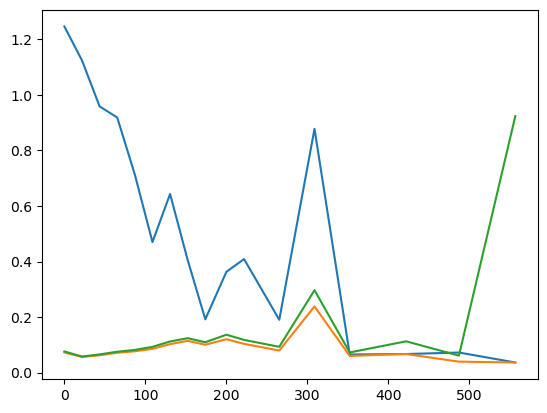

In [63]:
plt.plot(rads[0][:-2], mets[:-1])

In [52]:
ann_spec.obs_ids

['0720252501']

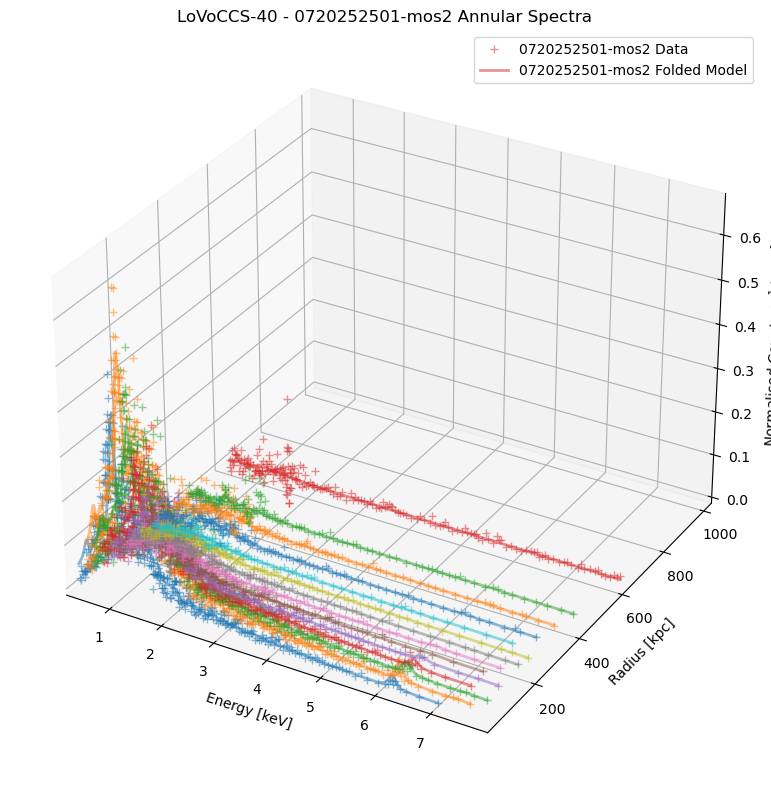

In [54]:
ann_spec.view_annuli('0720252501', 'mos2', 'constant*tbabs*apec')

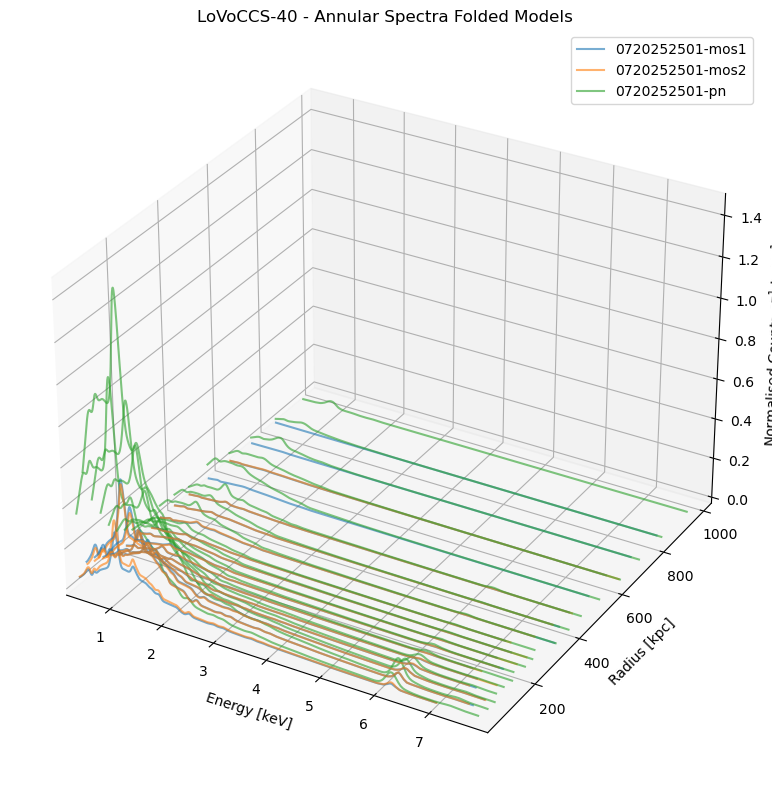

In [55]:
ann_spec.view('constant*tbabs*apec')

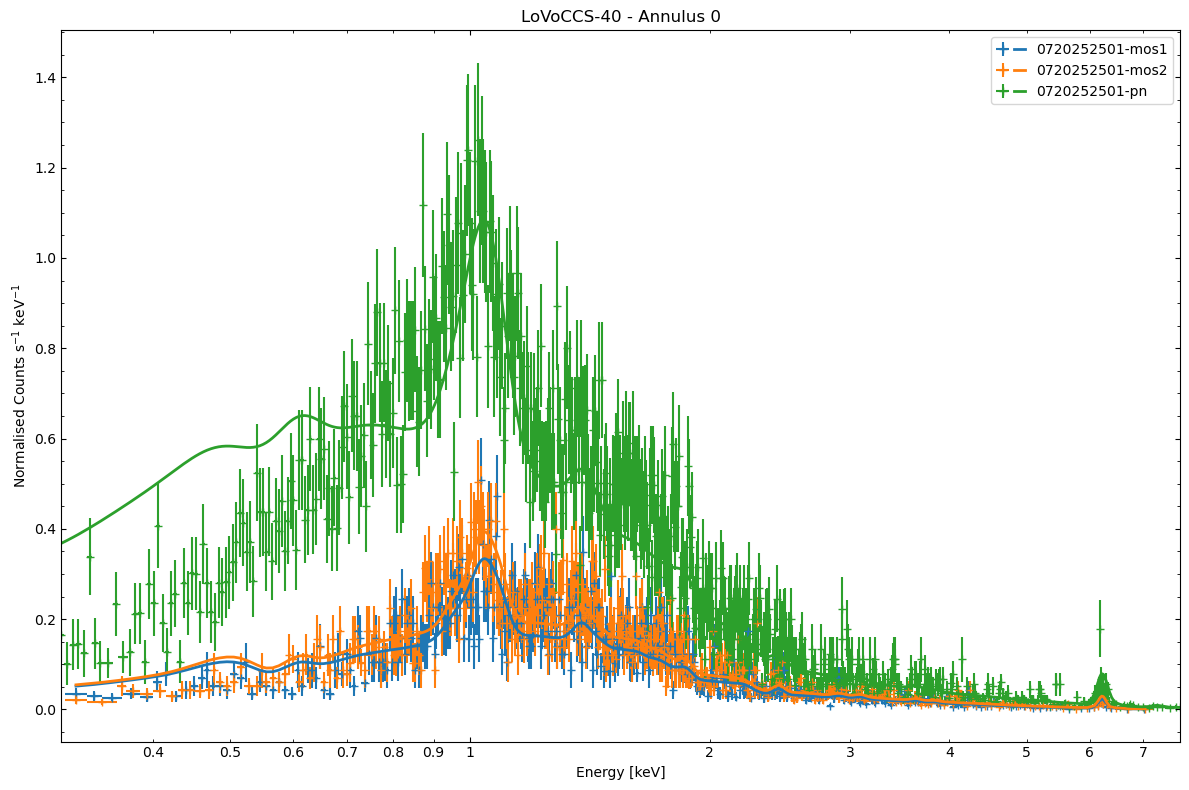

In [56]:
ann_spec.view_annulus(0, 'constant*tbabs*apec')

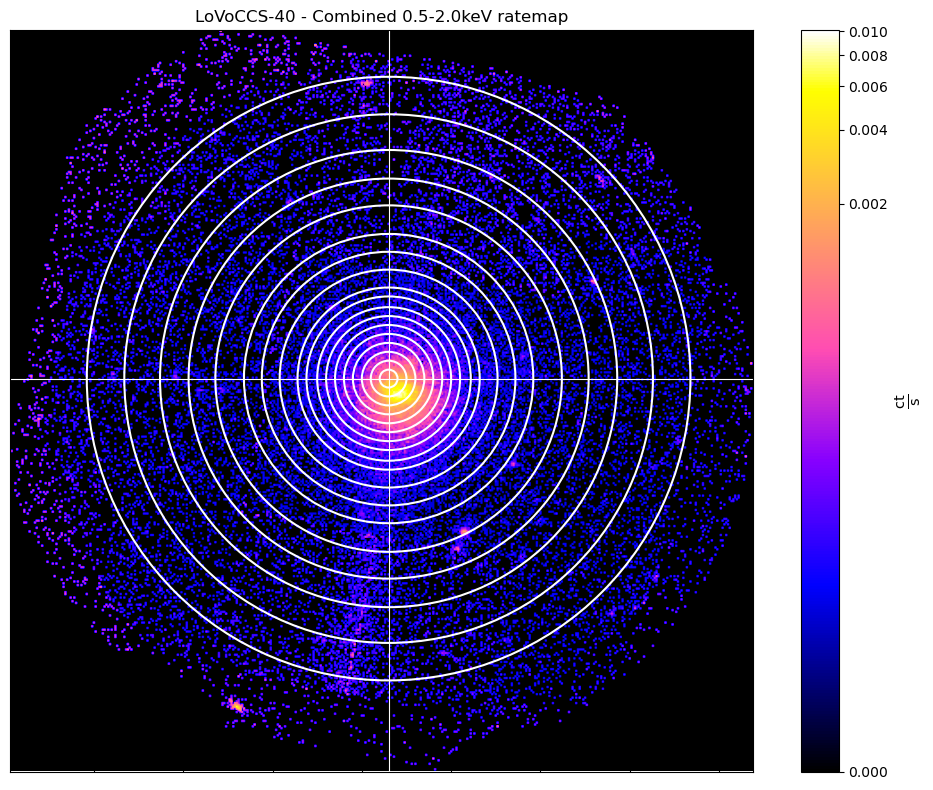

In [78]:
rt = srcs['LoVoCCS-40'].get_combined_ratemaps()
pix_rads = physical_rad_to_pix(rt, rads[0], srcs['LoVoCCS-40'].ra_dec, srcs['LoVoCCS-40'].redshift, 
                               srcs['LoVoCCS-40'].cosmo)
rt.view(coord, zoom_in=True, radial_bins_pix=pix_rads.value)